In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D, concatenate,add
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow import concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"

#ds_file = "synthethic_holograms_ft_ac_complex_v0.nc"
#data_rescale = 255  # set to 1 or 255 depending on input file
#channel_name = "complex"

#ds_file = "synthethic_holograms_ft_ac_complex_amp_phase_v0.nc" # amplitude and phase
#data_rescale = 1  # set to 1 or 255 depending on input file
#channel_name = "complex"

ds_file = "synthethic_holograms_v0_ft_ac_real_imag_amplitude.nc"  # real, imaginary, amplitude
data_rescale = 1  # set to 1 or 255 depending on input file
channel_name = "channels"

#ds_file = "synthethic_holograms_ft_ac_v0.nc"  # amplitude only
#data_rescale = 255
#channel_name = None

ds = xr.open_dataset(ds_path+ds_file)  # file with mean (DC) value removed

In [3]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
all_labels = ds[["d","z"]].to_dataframe()
train_labels = all_labels.iloc[valid_index:split_index]
test_labels = all_labels.iloc[split_index:]
val_labels = all_labels.iloc[:valid_index]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_val_labels = pd.DataFrame(scaler.fit_transform(val_labels), index=val_labels.index, columns=val_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [4]:
if channel_name is None:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", 'xsize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", "xsize",channel_name)

In [5]:
scaled_in_data = in_data / data_rescale

In [11]:
filter_input1 = Input(shape=scaled_in_data[...,0:1].shape[1:])
filter_input2 = Input(shape=scaled_in_data[...,1:2].shape[1:])
filter_input3 = Input(shape=scaled_in_data[...,2:3].shape[1:])

# use average pooling for input
pool_1_ch1 = AveragePooling2D(pool_size=(4, 4))(filter_input1)
pool_1_ch2 = AveragePooling2D(pool_size=(4, 4))(filter_input2)
pool_1_ch3 = AveragePooling2D(pool_size=(4, 4))(filter_input3)
 

dense_1_ch1 = Dense(32, activation="relu")(pool_1_ch1)
dense_1_ch2 = Dense(32, activation="relu")(pool_1_ch2)
dense_1_ch3 = Dense(32, activation="relu")(pool_1_ch3)

concat = concatenate([dense_1_ch1,dense_1_ch2,dense_1_ch3],axis=-1)
flat = Flatten()(concat)

dense_2 = Dense(32, activation="relu")(flat)
dense_3 = Dense(16, activation="relu")(dense_2)
out = Dense(all_labels.shape[1])(dense_3)  # number of outputs determined by the parameters we are training to
mod = Model([filter_input1,filter_input2,filter_input3], out)
mod.compile(optimizer="adam", loss="mae", metrics=['acc'])
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 400, 600, 1) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 400, 600, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 400, 600, 1) 0                                            
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 100, 150, 1)  0           input_4[0][0]                    
____________________________________________________________________________________________

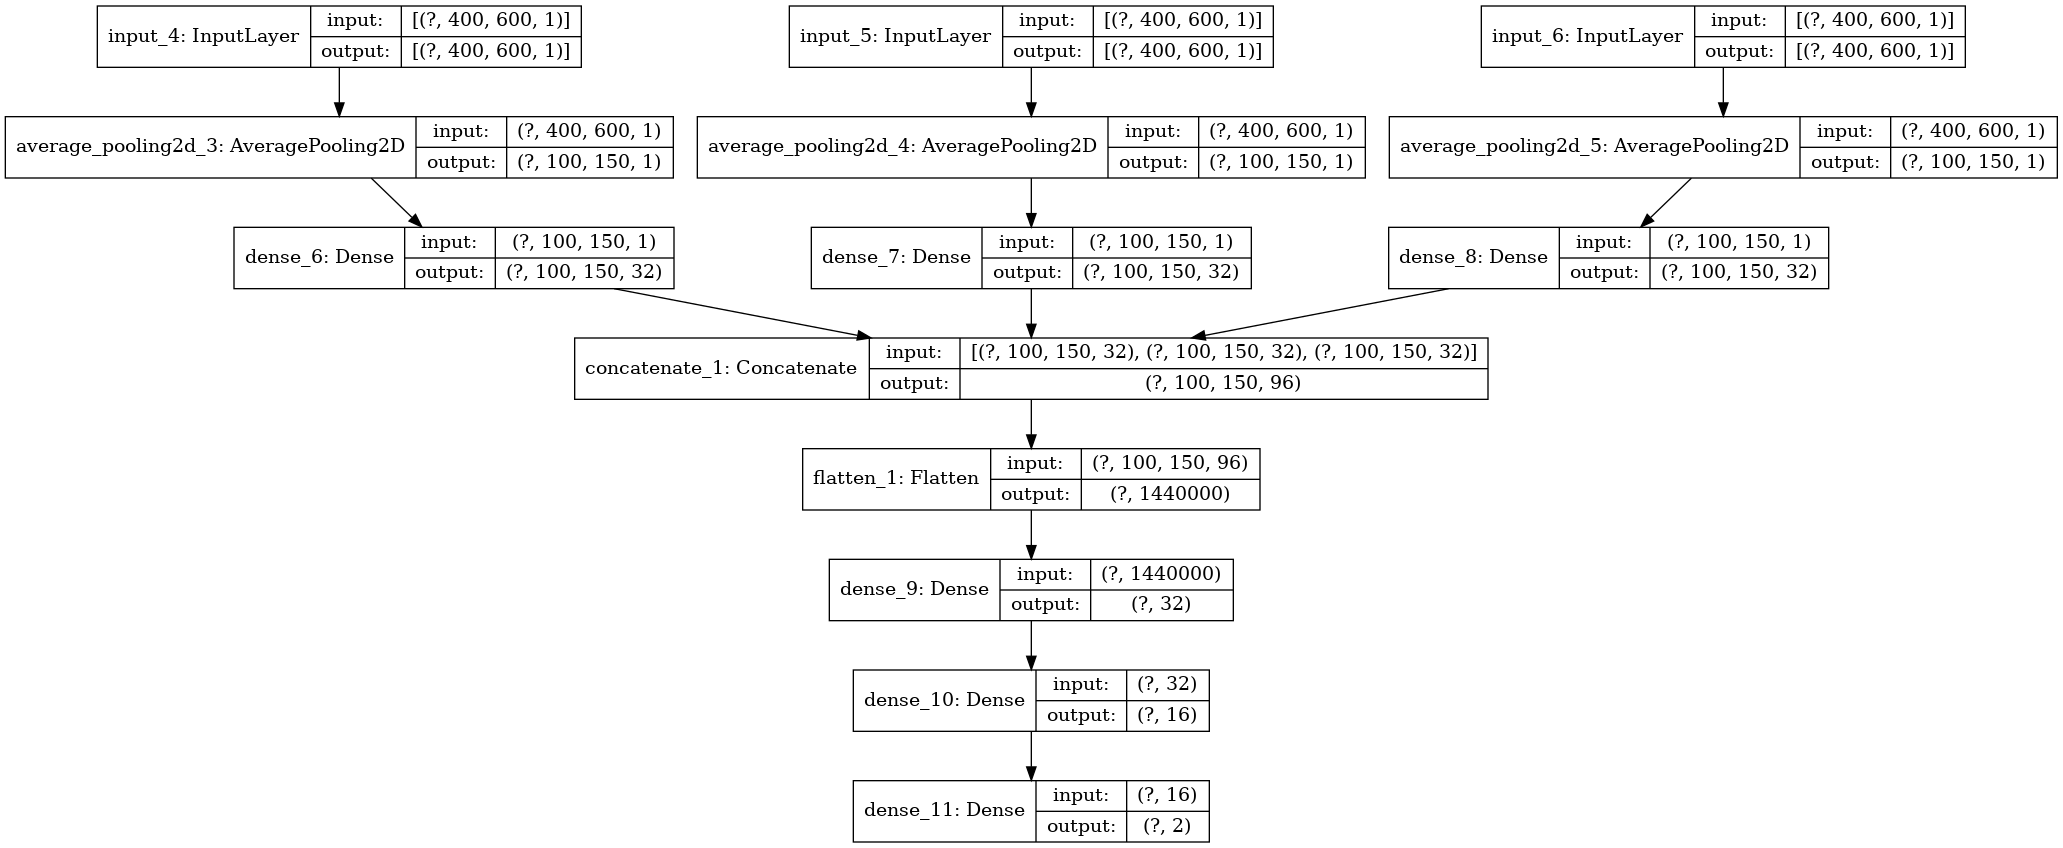

In [12]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+ds_file.replace(".nc","")+"".join(all_labels.columns)+"_denseNN_MultiIn.png")

In [35]:
scaled_train_data = [scaled_in_data[valid_index:split_index,...,0:1].values,
                     scaled_in_data[valid_index:split_index,...,1:2].values,
                     scaled_in_data[valid_index:split_index,...,2:3].values,]
scaled_valid_data = [scaled_in_data[:valid_index,...,0:1].values,
                     scaled_in_data[:valid_index,...,1:2].values,
                     scaled_in_data[:valid_index,...,2:3].values,]

In [32]:
len(scaled_train_data)

3

In [ ]:
history = mod.fit(scaled_train_data,
                  scaled_train_labels.values, 
                  batch_size=16, epochs=30, verbose=1,
                  validation_data=(scaled_valid_data,scaled_val_labels.values))

Train on 5000 samples, validate on 2000 samples
Epoch 1/30
5000/5000 [==============================] - 184s 37ms/sample - loss: 0.0879 - acc: 0.8778 - val_loss: 0.0432 - val_acc: 0.9495
Epoch 2/30
3072/5000 [=================>............] - ETA: 53s - loss: 0.0416 - acc: 0.9505

In [ ]:
epochs = np.arange(len(history.history['acc']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_denseNN_MultiIn_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_denseNN_MultiIn_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")


In [ ]:
# can skip the training process and just load the CNN model
# mod = load_model("holodec_ft_dxyz_cnn.h5")

In [ ]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

In [ ]:
save_model(mod, "results/holodec_"+ds_file.replace(".nc","")+"".join(all_labels.columns)+"_denseNN_MultiIn.h5", save_format="h5")

In [ ]:
preds_original = scaler.inverse_transform(preds_out)

In [ ]:
(test_labels.max() - test_labels.min())

In [ ]:
mean_error = np.mean(preds_original[split_index:] - test_labels.values, axis=0)
std_error = np.std(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
validation_data = {}
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
    plt.text(0.1,0.9,f"${mean_error[a]:.1f} \pm {std_error[a]:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
    validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
    validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("results/error_scatter_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")
validation_data_df = pd.DataFrame(validation_data)
validation_data_df.to_csv('results/validation_data_denseNN_MultiIn_'+ds_file.replace(".nc","_")+''.join(all_labels.columns)+'.txt')
    

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+test_labels.columns[a])
plt.savefig("results/relative_error_histogram_denseNN_MultiIn_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")

In [ ]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

In [ ]:
np.mean(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
np.std(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

In [ ]:
ds["xsize"]